In [21]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import seaborn as sns

In [22]:
data = pd.read_csv(r"CLEAN_DATA/2005-2020_percountry_peryear_final.csv")
data.head()

,Unnamed: 0.1,Unnamed: 0,countryname,year,rile,stance_positivity_score,gini Coefficient,leading,welfare spending,electoral_dem_ind,GNI,variable_interaction
0,0,0,Sweden,2006,-8.132000,34.300000,0.263525,left,26.408,0.915,4.340743e+11,-2.925581e+15
1,1,7,Sweden,2010,-4.296375,34.593625,0.277382,left,25.849,0.915,5.092813e+11,-1.790279e+15
2,2,15,Sweden,2014,-15.754750,54.500250,0.283897,left,26.587,0.916,5.942473e+11,-1.242631e+16
3,3,23,Sweden,2018,-10.283625,58.764000,0.299742,left,25.633,0.909,5.665538e+11,-7.977412e+15
4,4,31,Norway,2005,-15.257286,37.567143,0.305976,left,20.737,0.892,3.133711e+11,-3.322424e+15


In [23]:
#drop first two columns
data = data.drop(data.columns[[0, 1]], axis=1)

In [24]:
data.shape

(148, 10)

### Data cleaning

Split leading and rile variables

In [25]:
data.leading.value_counts()
#make values in the leading variable 1 or 0
data['leading'] = data['leading'].replace('right', 1)
data['leading'] = data['leading'].replace('left', 0)
data['leading'] = data['leading'].astype(int)
data.leading.value_counts()

C:\Users\sebgr\AppData\Local\Temp\ipykernel_13192\4195040618.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['leading'] = data['leading'].replace('left', 0)


leading
0    96
1    52
Name: count, dtype: int64

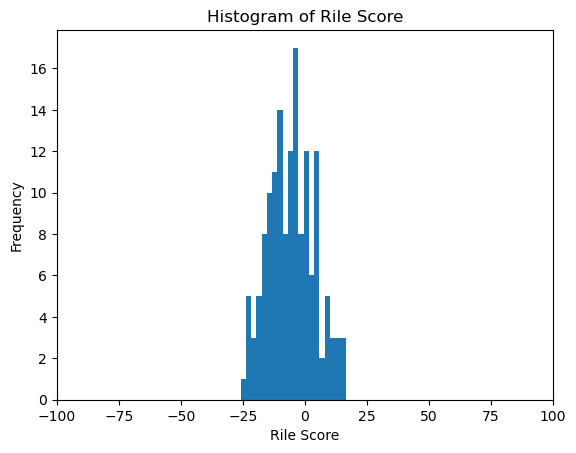

In [26]:
#plot histogram of rile score
plt.hist(data['rile'], bins=20)
plt.xlabel('Rile Score')
plt.ylabel('Frequency')
plt.xlim(-100,100)
plt.title('Histogram of Rile Score')
plt.show()

In [27]:
#calculate quantiles and cut on these quantiles
rile_quantiles = data['rile'].quantile([0,0.2, 0.4, 0.6, 0.8, 1])#make more quantile
data['rile_score'] = pd.cut(data['rile'], bins=rile_quantiles, labels=False)
#data['rile_score'] = pd.cut(data['rile'], bins=bins, labels=labels)

data.rile_score.value_counts()

rile_score
2.0    30
4.0    30
0.0    29
1.0    29
3.0    29
Name: count, dtype: int64

In [28]:
# linear regression
data.dropna(inplace=True, how='any')
X = data[[
    'rile',
    "stance_positivity_score",
    "welfare spending",
    "electoral_dem_ind",
    "GNI",
    "leading",
    "variable_interaction"]]
y = data['gini Coefficient']

# initialize model
model = LinearRegression()

# fit model
model.fit(X,y)

# predict gini values
y_pred = model.predict(X)

# Calculate mean squared error
mse = mean_squared_error(y, y_pred)

# Print the coefficients and MSE
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])
print("Mean Squared Error:", mse)


Intercept: 0.3525356244946214
Coefficient: 0.0004776498192786733
Mean Squared Error: 0.0010250810612604739


In [29]:
#sumarise model in a table
coefficients = model.coef_
coefficients = np.insert(coefficients, 0, model.intercept_)
coefficients = np.round(coefficients, 4)
columns = ['Intercept'] + list(X.columns)
summary = pd.DataFrame(coefficients, columns, columns=['Coefficient'])
summary

,Coefficient
Intercept,0.3525
rile,0.0005
stance_positivity_score,0.0001
welfare spending,-0.0021
electoral_dem_ind,-0.0000
GNI,0.0000
leading,0.0000
variable_interaction,-0.0000


In [30]:
coefficients = model.coef_
country_profiles = X.columns

# Create a dictionary to store country profiles and their coefficients
profile_coefficients = dict(zip(country_profiles, coefficients))

# Sort the dictionary by coefficient value
sorted_profile_coefficients = sorted(profile_coefficients.items(), key=lambda x: x[1], reverse=True)

# Print 
for profile, coefficient in sorted_profile_coefficients:
    print(f"Country Profile: {profile}, Coefficient: {coefficient}")


Country Profile: rile, Coefficient: 0.0004776498192786733
Country Profile: stance_positivity_score, Coefficient: 9.116131869609015e-05
Country Profile: leading, Coefficient: 4.6375569172684125e-05
Country Profile: GNI, Coefficient: 7.98804625844222e-15
Country Profile: variable_interaction, Coefficient: -2.9464505493748393e-19
Country Profile: electoral_dem_ind, Coefficient: -5.032962193703e-06
Country Profile: welfare spending, Coefficient: -0.0021368987100478668


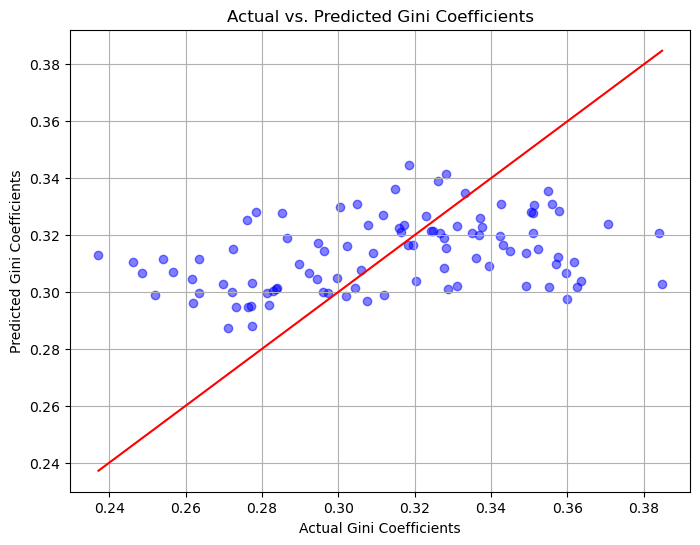

In [31]:
#getting the actual and predicted gini values
y_actual = data['gini Coefficient']

#plotting relationship between actual and predicted values of gini
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red')  # Diagonal line for reference
plt.title('Actual vs. Predicted Gini Coefficients')
plt.xlabel('Actual Gini Coefficients')
plt.ylabel('Predicted Gini Coefficients')
plt.grid(True)
plt.show()

### Model

In [32]:
X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data['Predicted_Gini'] = model.predict(X)

# Use statsmodels to further analyze the regression
X_with_intercept = sm.add_constant(X)  # Add intercept to X for statsmodels
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X_with_intercept])
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                      -3.058
Model:                            OLS   Adj. R-squared:                 -3.142
Method:                 Least Squares   F-statistic:                    -36.17
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               1.00
Time:                        08:30:05   Log-Likelihood:                 123.79
No. Observations:                  99   AIC:                            -241.6
Df Residuals:                      96   BIC:                            -233.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.34e-05   2.79e-06     33.448      0.0

### Tasks to still complete

* transform our data
* plot the linear regression model for each variable 
* test for collinearity between different variables - and possibly weight them
* standardize the data between 0 and 1

Below is the linear regression model for each variable

                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                      -3.102
Model:                            OLS   Adj. R-squared:                 -3.187
Method:                 Least Squares   F-statistic:                    -36.30
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               1.00
Time:                        08:30:05   Log-Likelihood:                 123.26
No. Observations:                  99   AIC:                            -240.5
Df Residuals:                      96   BIC:                            -232.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    9

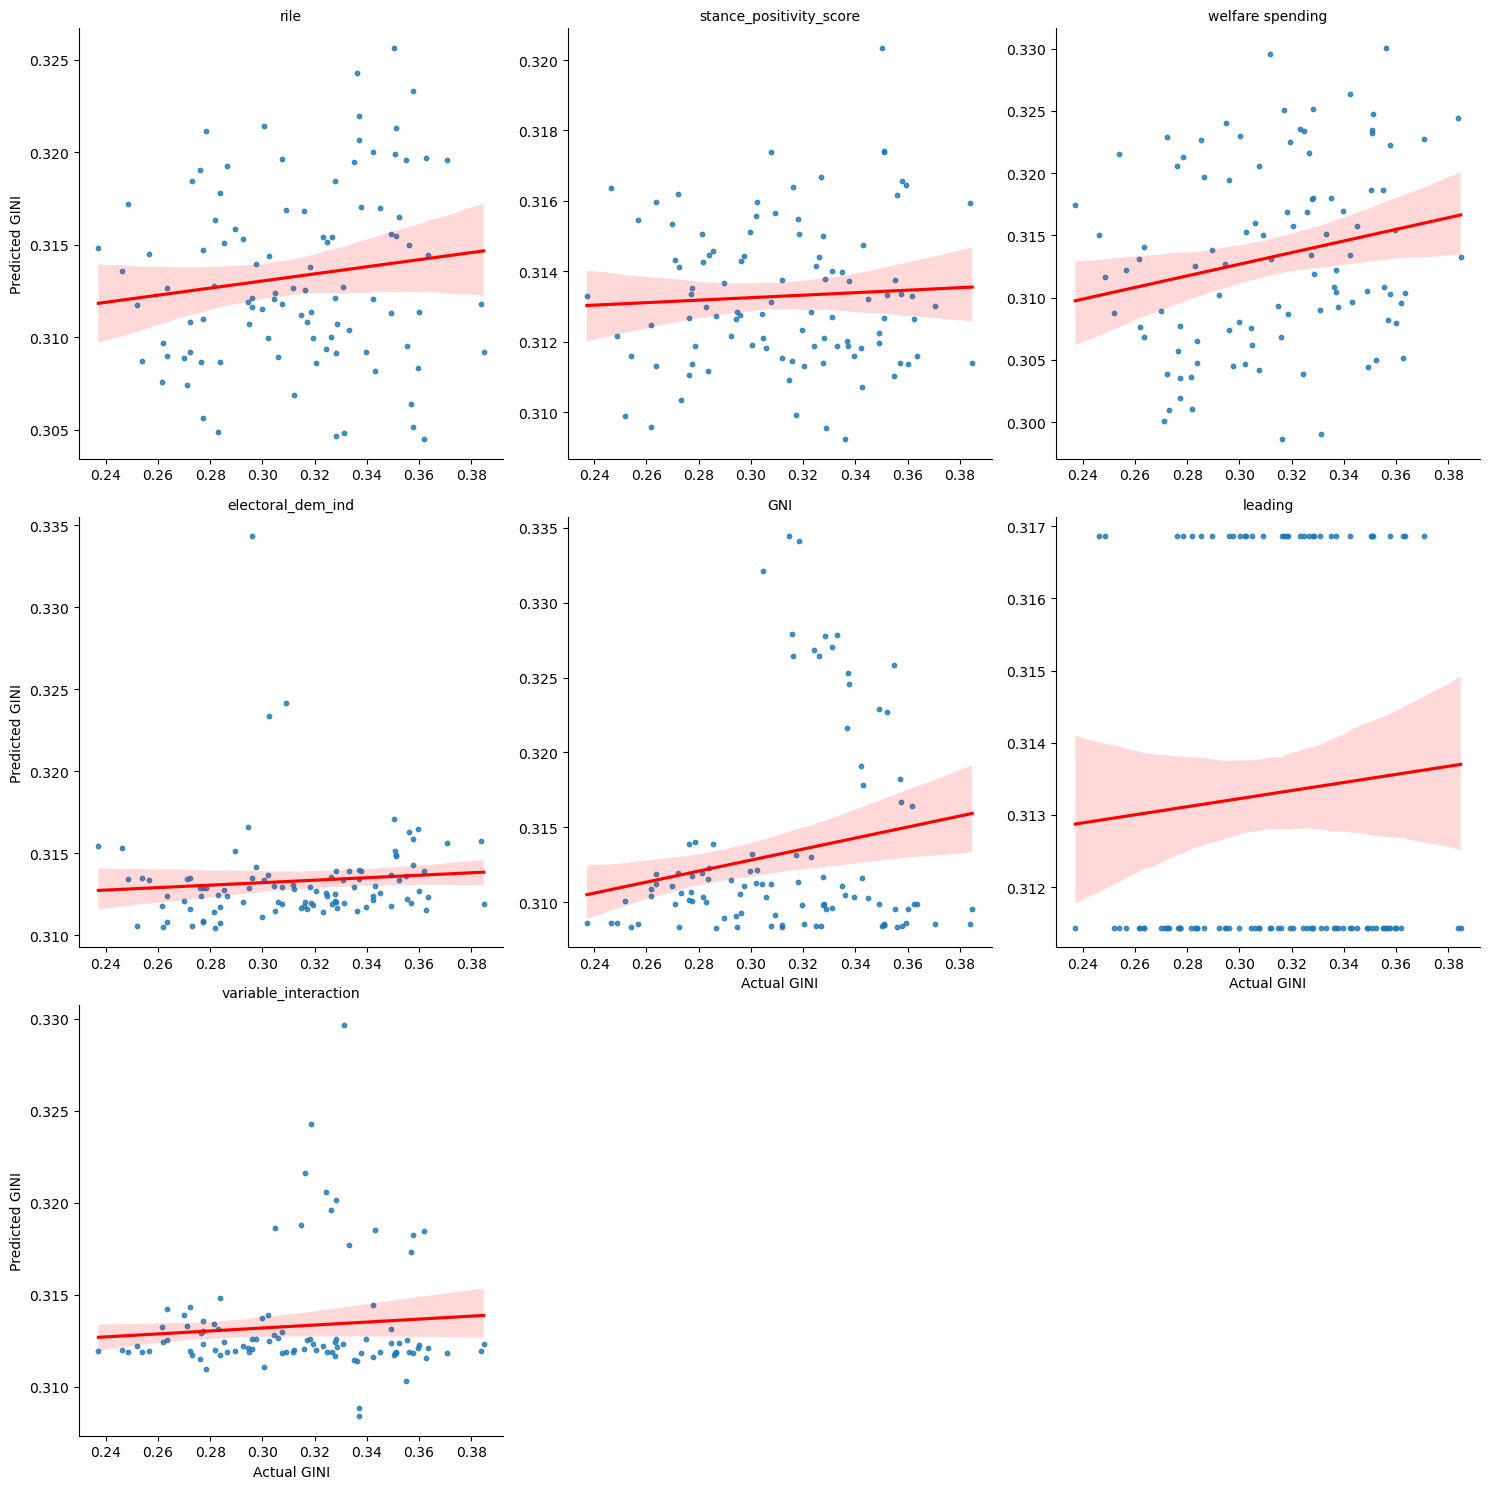

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model for combined model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data['Predicted_Gini'] = model.predict(X)

# Use statsmodels to further analyze the regression
X_with_intercept = sm.add_constant(X)  # Add intercept to X for statsmodels
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())

# Prepare data for individual models
plot_data = pd.DataFrame({
    'Actual_GINI': y
})

for column in X.columns:
    X_single = X[[column]]
    model_single = LinearRegression()
    model_single.fit(X_single, y)
    predicted_gini = model_single.predict(X_single)
    plot_data[column] = predicted_gini

# Melt the DataFrame for seaborn FacetGrid
plot_data_melted = plot_data.melt(id_vars=['Actual_GINI'], var_name='Predictor', value_name='Predicted_GINI')

# Create the FacetGrid
g = sns.FacetGrid(plot_data_melted, col='Predictor', col_wrap=3, height=5, sharex=False, sharey=False)

# Map the scatter plot to each facet
g.map(sns.regplot, 'Actual_GINI', 'Predicted_GINI', scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Add titles and labels
g.set_axis_labels("Actual GINI", "Predicted GINI")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

Below the test for multicollinearity

In [34]:
#Geeks-for-geeks has a nice tutorial on their website on how to do this
#so this is a copy (kind of)
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# the independent variables set 
X = X
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
print(vif_data)

                   feature       VIF
0                     rile  1.339716
1  stance_positivity_score  0.502547
2         welfare spending  0.417240
3        electoral_dem_ind  0.075651
4                      GNI  1.444236
5                  leading  1.058310
6     variable_interaction  3.525210


**Interpreting VIF:**
<br>
VIF = 1: No correlation between the predictor and the other variables.
1 < VIF < 5: Moderate correlation.
VIF >= 5: High correlation.
VIF > 10: Very high correlation, indicating multicollinearity problems.

Yay looks good in terms of multicollinearity

Now look into standardizing the data and then running the regression again.

In [35]:
#convert all values in the X dataframe to values between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.describe()

,rile,stance_positivity_score,welfare spending,electoral_dem_ind,GNI,leading,variable_interaction
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.416167,0.365720,0.533326,0.880882,0.191330,0.343434,0.769552
std,0.226666,0.185031,0.237761,0.125802,0.253779,0.477272,0.145915
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.241461,0.235233,0.350362,0.866743,0.031435,0.000000,0.777755
50%,0.373565,0.336639,0.553667,0.906606,0.085705,0.000000,0.818391
75%,0.575854,0.475459,0.712526,0.940774,0.187370,1.000000,0.835780
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Save standardized values as csv

In [36]:
#join X_scaled and y
data_standardized = pd.concat([X_scaled.reset_index(), y.reset_index()],axis=1)
data_standardized.dropna(inplace=True, how='any')
data_standardized.to_csv(r"CLEAN_DATA/2005-2020_percountry_peryear_final_scaled.csv")

In [52]:
X_scaled

,rile,stance_positivity_score,welfare spending,electoral_dem_ind,GNI,leading,variable_interaction
0,0.387241,0.187414,0.739773,0.986333,0.111169,0.0,0.804046
1,0.483279,0.191529,0.710899,0.986333,0.130910,0.0,0.816592
2,0.196378,0.470511,0.749019,0.988610,0.153212,0.0,0.699058
3,0.333367,0.530266,0.699742,0.972665,0.145943,0.0,0.748221
4,0.208834,0.233201,0.446849,0.933941,0.079486,0.0,0.799661
...,...,...,...,...,...,...,...
94,0.468852,0.605566,0.470041,0.460137,0.147152,1.0,0.807792
95,0.489483,0.364440,0.402583,0.790433,0.011488,0.0,0.834495
96,0.601651,0.263971,0.586519,0.874715,0.010586,1.0,0.836571
97,0.473341,0.561094,0.568337,0.879271,0.010233,0.0,0.833236


In [49]:
data_standardized

,level_0,index,rile,stance_positivity_score,welfare spending,electoral_dem_ind,GNI,leading,variable_interaction,index,gini Coefficient,Predicted_Gini,index,rile_score
0,0,0,0.387241,0.187414,0.739773,0.986333,0.111169,0.0,0.804046,0,0.263525,0.309646,0,2.0
1,1,1,0.483279,0.191529,0.710899,0.986333,0.130910,0.0,0.816592,1,0.277382,0.316242,1,2.0
2,2,2,0.196378,0.470511,0.749019,0.988610,0.153212,0.0,0.699058,2,0.283897,0.300686,2,0.0
3,3,3,0.333367,0.530266,0.699742,0.972665,0.145943,0.0,0.748221,3,0.299742,0.307932,3,1.0
4,4,4,0.208834,0.233201,0.446849,0.933941,0.079486,0.0,0.799661,4,0.305976,0.308925,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,94,0.468852,0.605566,0.470041,0.460137,0.147152,1.0,0.807792,123,0.302395,0.311590,123,2.0
95,95,95,0.489483,0.364440,0.402583,0.790433,0.011488,0.0,0.834495,139,0.237180,0.325838,139,2.0
96,96,96,0.601651,0.263971,0.586519,0.874715,0.010586,1.0,0.836571,140,0.248680,0.311501,140,3.0
97,97,97,0.473341,0.561094,0.568337,0.879271,0.010233,0.0,0.833236,141,0.256575,0.316039,141,2.0


Rerun everything with the now standardized data

In [54]:
'''
DEPRECATED CODE

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data_standardized['Predicted_Gini'] = model.predict(X_scaled)

# Use statsmodels to further analyze the regression
X_scaled_with_intercept = sm.add_constant(X_scaled)  # Add intercept to X_scaled for statsmodels
X_scaled_with_intercept = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled_with_intercept])
model = sm.OLS(y, X_scaled_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())'''

"\nDEPRECATED CODE\n\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# Linear regression model\nmodel = LinearRegression()\n\n# Train the model\nmodel.fit(X_train, y_train)\n\n# Get the coefficients\ncoefficients = model.coef_\nintercept = model.intercept_\n\n# Combine coefficients into a single array for statsmodels\ncoefficients_statsmodels = np.concatenate(([intercept], coefficients))\n\n# Predict Gini index values on training and testing sets\npredicted_gini_train = model.predict(X_train)\npredicted_gini_test = model.predict(X_test)\n\n# Evaluate the model\ntrain_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)\ntest_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)\ntrain_r2 = r2_score(y_train, predicted_gini_train)\ntest_r2 = r2_score(y_test, predicted_gini_test)\n\n# Add predicted Gini index to the DataFrame\ndata_standardized['Predicted_Gini'] = model.predict(X_scaled)\n\n# Use stats

In [55]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data_standardized['Predicted_Gini'] = model.predict(X_scaled)

# Use statsmodels to further analyze the regression
X_scaled_with_intercept = sm.add_constant(X_scaled)  # Add intercept to X_scaled for statsmodels

# Ensure X_scaled is a DataFrame with column names
if isinstance(X_scaled, np.ndarray):
    X_scaled = pd.DataFrame(X_scaled, columns=[f'x{i}' for i in range(1, X_scaled.shape[1] + 1)])

# Add intercept to X_scaled for statsmodels
X_scaled_with_intercept = sm.add_constant(X_scaled)

# Fit the model
model = sm.OLS(y, X_scaled_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.091
Date:                Thu, 06 Jun 2024   Prob (F-statistic):             0.0523
Time:                        09:32:35   Log-Likelihood:                 200.50
No. Observations:                  99   AIC:                            -385.0
Df Residuals:                      91   BIC:                            -364.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Looking into rile-score categorisation

In [38]:
#join data['rile_score'] to data_standardized
data_standardized = pd.concat([data_standardized.reset_index(), data['rile_score'].reset_index()],axis=1)
data_standardized.head()

,level_0,index,rile,stance_positivity_score,welfare spending,electoral_dem_ind,GNI,leading,variable_interaction,index,gini Coefficient,Predicted_Gini,index,rile_score
0,0,0,0.387241,0.187414,0.739773,0.986333,0.111169,0.0,0.804046,0,0.263525,0.309646,0,2.0
1,1,1,0.483279,0.191529,0.710899,0.986333,0.130910,0.0,0.816592,1,0.277382,0.316242,1,2.0
2,2,2,0.196378,0.470511,0.749019,0.988610,0.153212,0.0,0.699058,2,0.283897,0.300686,2,0.0
3,3,3,0.333367,0.530266,0.699742,0.972665,0.145943,0.0,0.748221,3,0.299742,0.307932,3,1.0
4,4,4,0.208834,0.233201,0.446849,0.933941,0.079486,0.0,0.799661,4,0.305976,0.308925,4,0.0


In [43]:
data_standardized.dropna(inplace=True, how='any')
X = data_standardized[[
    'rile',
    "stance_positivity_score",
    "welfare spending",
    "electoral_dem_ind",
    "GNI",
    "leading",
    "variable_interaction"]]
y = data_standardized['gini Coefficient']

In [46]:
# linear regression but seperate for each rile_score category
#so that every rile score category has its own model
# Unique rile_score categories
rile_scores = data_standardized['rile_score'].unique()

# Dictionary to store models for each rile_score category
models = {}

# Loop through each rile_score category and fit a model
for score in rile_scores:
    # Filter the dataset for the current rile_score category
    X_filtered = X[data_standardized['rile_score'] == score]
    y_filtered = y[data_standardized['rile_score'] == score]
    
    # Add a constant to the predictor variables matrix
    X_filtered = sm.add_constant(X_filtered)
    
    # Fit the OLS model
    model = sm.OLS(y_filtered, X_filtered).fit()
    
    # Print the summary
    print(f'OLS Regression Results for rile_score {score}:')
    print(model.summary())
    print()



OLS Regression Results for rile_score 2.0:
                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                 -0.112
Method:                 Least Squares   F-statistic:                    0.7838
Date:                Thu, 06 Jun 2024   Prob (F-statistic):              0.620
Time:                        08:41:49   Log-Likelihood:                 34.864
No. Observations:                  16   AIC:                            -53.73
Df Residuals:                       8   BIC:                            -47.55
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

c:\Users\sebgr\.conda\envs\Uni\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\sebgr\.conda\envs\Uni\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\sebgr\.conda\envs\Uni\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Looks like the models improve following this division

### Try logistic regression now

Let's check if the logistic regression performs better

In [ ]:
features = ['rile', 'stance_positivity_score', 'gini Coefficient', 'welfare spending', 'electoral_dem_ind', 'GNI', 'variable_interaction']
target = 'leading'

In [ ]:
# Extract features and target from the DataFrame
X = data[features]
y = data[target]

# Convert boolean columns to numeric
X = X.astype(float)
y = y.astype(int)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
#split gini on the median
threshold = y.median()
y_binary = (y > threshold).astype(int)

#initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X, y_binary)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

y_pred = model.predict(X)

print('Classification Report:')
print(classification_report(y_binary, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_binary, y_pred))

Coefficients: [[ 0.35984546 -0.11659156 -1.53974582  0.31363884  1.07357317  0.17012445
  -0.56439251]]
Intercept: [0.58902295]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        50
           1       0.67      0.59      0.63        49

    accuracy                           0.66        99
   macro avg       0.66      0.66      0.65        99
weighted avg       0.66      0.66      0.66        99

Confusion Matrix:
[[36 14]
 [20 29]]
